# **Data preprocessing and modeling**

In [554]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import re

In [435]:
ev_cars = pd.read_csv('../data/ev_cars_cleaned.csv')

ev_cars.head()

,subreddit,title
0,cars,Need help for an article
1,cars,We have a 2014 Nissan Rogue. Just found out ab...
2,cars,Audi manual transmission?
3,cars,How much would a paint job cost to cover up tw...
4,cars,What car is Jeezy riding in this music video? ...


In [436]:
print(ev_cars.shape)
ev_cars.info()

(7447, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7447 entries, 0 to 7446
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7447 non-null   object
 1   title      7447 non-null   object
dtypes: object(2)
memory usage: 116.5+ KB


Everything looks in order for preprocessing work to begin. Before delving into any of that, I'll split `ev_cars` into a train and test set.

## Splitting into train and test sets

In [437]:
X_train, X_test, y_train, y_test = train_test_split(ev_cars['title'], 
                                                    ev_cars['subreddit'],
                                                    stratify= ev_cars['subreddit'],
                                                    test_size=0.25,
                                                    random_state=42
                                                   )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5585,), (1862,), (5585,), (1862,))

There are over 5_000 samples in our train set and almost 2_000 samples in our test set. This looks like a sizeable number to train a model and test it. I feel comfortable with this, so I'll proceed.  

## Baseline Accuracy - 58% as seen below

In [6]:
#The proportions of the two classes in our train and test sets approximates the proportion in our complete dataset
print(f'Proportion in the complete dataset')
print(ev_cars['subreddit'].value_counts(normalize=True))
print('-'*20)
print(f'Proportion in the training dataset')
print(y_train.value_counts(normalize=True))
print('-'*20)
print(f'Proportion in the test dataset')
print(y_test.value_counts(normalize=True))
print('-'*20)

Proportion in the complete dataset
cars                0.580905
electricvehicles    0.419095
Name: subreddit, dtype: float64
--------------------
Proportion in the training dataset
cars                0.580842
electricvehicles    0.419158
Name: subreddit, dtype: float64
--------------------
Proportion in the test dataset
cars                0.581096
electricvehicles    0.418904
Name: subreddit, dtype: float64
--------------------


The baseline accuracy is 58%, this - as seen above - represents the proportion of the majority class, which in our dataset is the `cars` subreddit. If our model performs worse than this baseline accuracy, it is useless. 

## Preprocessing with the CountVectorizer and initializing our first model

I previously used the CountVectorizer on the combined dataset for the purpose of EDA. I am going to use the CountVectorizer again now for my preprocessing and modeling. 

- This time I would set it up as the first stage of a pipeline. 
- The second stage of the pipeline would be an estimator. I have decided to start with a LogisticRegression model - which is a fast and versatile estimator. 
- Just like in my EDA notebook, I am going to define a custom stemmer, preprocessor, and I'll use english stopwords. 
- I'll also tune the hyperparameters in my pipeline, using a RandomizedSearchCV

In [133]:
#Defining a custom stemmer function
def my_stemmer(text):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(w) for w in text.split(" ")]

#ensuring the preprocessing is the same in my stopwords
stemmer = SnowballStemmer('english')
stem_stopwords = [stemmer.stem(w) for w in stopwords.words('english')]

#Custom preprocessor
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('\\n', '', text)
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = " ".join(text)
    
    return text

In [8]:
pipe_1 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('logr', LogisticRegression(random_state=42))
])

#the parameters of my pipeline that would be used for tuning in the RandomizedSearchCV
pipe_params1 = {
    'cvec__max_features': [2800, 3000, 3500, 4000, 10000, 11000, 11500],
    'cvec__min_df': [1, 2, 3, 4, 5],
    'cvec__max_df': [0.9, 0.95, 0.98],
   'cvec__ngram_range': [(1,2), (1,3), (2,2), (3,3)],
    'logr__C': [1.4, 1.5, 2, 3, 3.5, 4]
}

#Instantiate a RandomizedSearchCV
grid_1 = RandomizedSearchCV(pipe_1, param_distributions=pipe_params1, cv=3, n_jobs=-1, random_state=42)

#fit grid_1 on the training data
grid_1.fit(X_train, y_train)

#make predictions
y_pred_1 = grid_1.predict(X_test)

print(f'Train score: {grid_1.best_score_}')

print(f'The Test accuracy of this Logistic Regression model is: {grid_1.score(X_test, y_test)}')
print(f'The Misclassification rate of this Logistic Regression model is {1-grid_1.score(X_test, y_test)}')
print(f'The F1 score of this Logistic Regression model is {metrics.f1_score(y_test, y_pred_1, pos_label = "cars")}')

Train score: 0.866251373424734
The Test accuracy of this Logistic Regression model is: 0.8603651987110634
The Misclassification rate of this Logistic Regression model is 0.13963480128893657
The F1 score of this Logistic Regression model is 0.8839285714285714


In [9]:
grid_1.best_params_

{'logr__C': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__min_df': 1,
 'cvec__max_features': 10000,
 'cvec__max_df': 0.98}

**Some takeaways from this model**
1. Our accuracy for this model is 86.0%. That is much better than the baseline accuracy of 58%. 

2. In addition, the `best_score_` of 86.6% for our training data is close to the 86.0% obtained on our test data. This indicates that our model is not overfitting and is generalizing well to unseen data. 

3. The model is misclassifying almost 14 out of every 100 posts. Our target is a maximum of 10 misclassifications. 

4. At 0.88, our `F1 score` is high and indicates a good balance between our recall and precision scores, and shows that this is a good model.

## Next up, we would use a RandomForestClassifier 

In [11]:
pipe_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('rf', RandomForestClassifier(random_state=0))])

#the parameters of my pipeline that would be used for tuning in the GridSearchCV
pipe_params2 = {
    
    'cvec__min_df': [2, 3, 4, 5],
    'cvec__max_features': [7500, 9000, 10000, 11000, 12000],
    'cvec__max_df': [0.9, 0.95, 0.98, 0.99],
    'cvec__ngram_range': [(1,2), (1,3), (2,2), (2,3)],
    'rf__min_samples_split': [30, 40, 50, 70, 100],
    'rf__min_samples_leaf': [30, 40, 50, 60, 70],
    'rf__max_depth': [5,7,9,10],
    'rf__max_features': ['auto', 0.2, 0.3, 0.4, 'log2'],
    'rf__n_estimators': [2500, 3000, 3500, 4000]
}

grid_2 = RandomizedSearchCV(pipe_2, param_distributions=pipe_params2, cv=5, n_jobs=-1, n_iter=60, random_state=0)

#fit grid_2 on the training data
grid_2.fit(X_train, y_train)

#make predictions
y_pred_2 = grid_2.predict(X_test)

print(f'Train score: {grid_2.best_score_}')

print(f'The Test accuracy of this model is: {grid_2.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-grid_2.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_2, pos_label = "cars")}')

Train score: 0.8153983885407341
The Test accuracy of this model is: 0.8018259935553169
The Misclassification rate of this model is 0.19817400644468308
The F1 score of this model is 0.8459290187891441


In [12]:
grid_2.best_params_

{'rf__n_estimators': 4000,
 'rf__min_samples_split': 50,
 'rf__min_samples_leaf': 30,
 'rf__max_features': 0.3,
 'rf__max_depth': 10,
 'cvec__ngram_range': (1, 2),
 'cvec__min_df': 4,
 'cvec__max_features': 12000,
 'cvec__max_df': 0.95}

The performance of this Random Forest model is substantially worse than that of the Logistic Regression model. We only managed an accuracy of 80.2% compared in our test data. While this is better than the baseline, it is well short of the 90% target test accuracy. Despite this model being significantly less accurate than the previous one, the F1 score of 0.85 is quite close to the 0.88 obtained in previous model. This indicates a good model.

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|

## Next up - Multinomial Naive Bayes

In [13]:
pipe_3 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('mnb', MultinomialNB())
])

#the parameters of my pipeline that would be used for tuning in the GridSearchCV
pipe_params3 = {
    'cvec__max_features': [9000, 10000, 11000, 12000, 13000],
   'cvec__min_df': [1, 2, 3, 5, 6],
   'cvec__max_df': [0.95, 0.98, 0.99],
   'cvec__ngram_range': [(1,2), (1,3), (2,2), (1,1)],
    'mnb__alpha': [0.1, 0.05, 0.5, 1.0]
    } 

#Instantiate a RandomizedSearchCV
grid_3 = RandomizedSearchCV(pipe_3, param_distributions=pipe_params3, cv=5, n_jobs=-1, random_state=0)


grid_3.fit(X_train, y_train)

#make predictions
y_pred_3 = grid_3.predict(X_test)

print(f'Train score: {grid_3.best_score_}')

print(f'The Test accuracy of this model is: {grid_3.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-grid_3.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_3, pos_label = "cars")}')

Train score: 0.8658907788719785
The Test accuracy of this model is: 0.8539205155746509
The Misclassification rate of this model is 0.14607948442534913
The F1 score of this model is 0.8710900473933649


In [14]:
grid_3.best_params_

{'mnb__alpha': 1.0,
 'cvec__ngram_range': (1, 2),
 'cvec__min_df': 3,
 'cvec__max_features': 9000,
 'cvec__max_df': 0.99}

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.4%|14.6%|0.87|

At this point, since my three models so far have failed to achieve my target accuracy, I would like to tackle this classification problem via other ensemble methods, with the expectation that combining multiple models together would produce a more powerful model. Next would be a Bagging Classifier, using LogisticRegression as the base estimator (even though LR model do not overfit easily, I have decided to use this in my Bagging Classifier just because the LR model has performed the best of all my models so far). 

## Bagging Classifier

In [15]:
pipe_4 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('bag', BaggingClassifier(base_estimator=LogisticRegression(), random_state=42, n_jobs=-1))
])

pipe_params4 = {
    'cvec__max_features': [10000, 11000, 12000, 13000],
    'cvec__min_df': [2, 3, 5],
    'cvec__max_df': [0.95, 0.98, 0.99],
   'cvec__ngram_range': [(1,2), (1,3), (2,2), (1,1)],
    'bag__n_estimators': [10, 50, 100, 150],
    'bag__base_estimator__C': [0.001, 2.5, 3, 3.5]
}


grid_4 = RandomizedSearchCV(pipe_4, param_distributions=pipe_params4, cv=5, n_jobs=-1, random_state=0)

grid_4.fit(X_train, y_train)

#make predictions
y_pred_4 = grid_4.predict(X_test)

print(f'Train score: {grid_4.best_score_}')

print(f'The Test accuracy of this model is: {grid_4.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-grid_4.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_4, pos_label = "cars")}')

/Users/stanleyaz/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Train score: 0.8689346463742167
The Test accuracy of this model is: 0.8678839957035446
The Misclassification rate of this model is 0.13211600429645542
The F1 score of this model is 0.8906666666666667


In [16]:
grid_4.best_params_

{'cvec__ngram_range': (1, 3),
 'cvec__min_df': 2,
 'cvec__max_features': 12000,
 'cvec__max_df': 0.95,
 'bag__n_estimators': 150,
 'bag__base_estimator__C': 2.5}

The above bagged classifier using Logistic Regression as the base estimator is now slightly our best model so far with a test accuracy of 86.8%, and an F1 score of almost 0.9.  

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|

Can we try this bagging method again, using a Random Forest classifier instead? 

In [21]:
pipe_5 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('bag', BaggingClassifier(base_estimator=RandomForestClassifier()))
])

pipe_params5 = {
    'cvec__max_features': [10000, 11000],
    'cvec__min_df': [2, 3, 5],
    'cvec__max_df': [0.95, 0.98],
   'cvec__ngram_range': [(1,2), (1,3)],
    #'bag__n_estimators': [100, 150, 200],
    'bag__base_estimator__max_depth': [200, 250, 300],
    'bag__base_estimator__n_estimators': [150, 400]
}


grid_5 = RandomizedSearchCV(pipe_5, param_distributions=pipe_params5, cv=5, n_jobs=-1, random_state=0)

grid_5.fit(X_train, y_train)

#make predictions
y_pred_5 = grid_5.predict(X_test)

print(f'Train score: {grid_5.best_score_}')

print(f'The Test accuracy of this model is: {grid_5.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-grid_5.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_5, pos_label = "cars")}')

/Users/stanleyaz/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Train score: 0.8726947179946285
The Test accuracy of this model is: 0.8651987110633728
The Misclassification rate of this model is 0.13480128893662724
The F1 score of this model is 0.8872923215087561


In [22]:
grid_5.best_params_

{'cvec__ngram_range': (1, 2),
 'cvec__min_df': 3,
 'cvec__max_features': 10000,
 'cvec__max_df': 0.95,
 'bag__base_estimator__n_estimators': 400,
 'bag__base_estimator__max_depth': 200}

The two bagging models I have built have similar performances. Approximately equal R1 scores of 0.89, and an accuracy of over 86%. The LR base estimator bagging model only slightly outperforms the RF base estimator, but as noted earlier, it still falls a amall percentage short of our target.

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|
|5|Bagged Classifier with RF base estimator|86.5%|13.5%|0.89|

Next, I am going to attempt a boosting technique. Boosting is generally thought to reduce bias which is what I am hoping to achieve in this problem. My preferred boosting technique for this problem would be the GradientBoosting classifier.

## GradientBoosting Classifier

In [34]:
pipe_6 = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)),
    ('gb', GradientBoostingClassifier(random_state=0, max_features='sqrt'))
])

pipe_params6 = {
    'cvec__max_features': [10000, 11000, 12000],
    'cvec__min_df': [2, 3, 5],
    'cvec__max_df': [0.95, 0.98, 0.99],
   'cvec__ngram_range': [(1,2), (1,3), (2,2)],
    'gb__learning_rate': [0.8, 0.1, 1.0],
    'gb__max_depth': [10, 5, 7, 2],
    'gb__n_estimators': [100, 125, 300],
}


grid_6 = RandomizedSearchCV(pipe_6, param_distributions=pipe_params6, cv=5, n_jobs=-1, random_state=0)

grid_6.fit(X_train, y_train)

#make predictions
y_pred_6 = grid_6.predict(X_test)

print(f'Train score: {grid_6.best_score_}')

print(f'The Test accuracy of this model is: {grid_6.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-grid_6.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_6, pos_label = "cars")}')

Train score: 0.8725156669650851
The Test accuracy of this model is: 0.864124597207304
The Misclassification rate of this model is 0.13587540279269605
The F1 score of this model is 0.887305122494432


In [35]:
grid_6.best_params_

{'gb__n_estimators': 300,
 'gb__max_depth': 10,
 'gb__learning_rate': 0.1,
 'cvec__ngram_range': (1, 3),
 'cvec__min_df': 3,
 'cvec__max_features': 12000,
 'cvec__max_df': 0.98}

It appears most of our ensemble models are performing similarly. THis boosting model has same F1 score as the last two and similar accuracy as well.

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|
|5|Bagged Classifier with RF base estimator|86.5%|13.5%|0.89|
|6|Gradient Boosting|86.4%|13.6%|0.89|

## Voting Classifier

In [58]:
#Going to use logistic regression, MNB, adaboost and gradient boost in pipelines that would be fed into my voting classifier

logr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('logr', LogisticRegression())])
    
mnb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('mnb', MultinomialNB())])

ada_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression()))])

gb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('gb', GradientBoostingClassifier())])

vote = VotingClassifier([
    ('logr_pipe', logr_pipe),
    ('mnb_pipe', mnb_pipe),
    ('ada_pipe', ada_pipe),
    ('gb_pipe', gb_pipe)
], voting='soft', n_jobs=-1)

#Fit
vote.fit(X_train, y_train)

#predict
y_pred_8 = vote.predict(X_test)

print(f'Train accuracy: {cross_val_score(vote, X_train, y_train).mean()}')

# Test score
print(f'The Test accuracy of this model is: {vote.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-vote.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_8, pos_label = "cars")}')

Train accuracy: 0.8825425246195167
The Test accuracy of this model is: 0.8711063372717508
The Misclassification rate of this model is 0.1288936627282492
The F1 score of this model is 0.8924731182795699


|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|
|5|Bagged Classifier with RF base estimator|86.5%|13.5%|0.89|
|6|Gradient Boosting|86.4%|13.6%|0.89|
|7|Voting Classifier|87.1%|12.9%|0.89|

## Stacked Classifier

In [51]:
# Create the model using four level one estimators - logr, mnb, rf and bagging. The final estimator would be a logistic reg
l1_estimator = [
    ('logr_pipe', Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('logr', LogisticRegression())])),
    ('mnb_pipe', Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('mnb', MultinomialNB())])),
    ('rf_pipe', Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('rf', RandomForestClassifier())])),
    ('bag_pipe', Pipeline([
    ('cvec', CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))),
    ('bag', BaggingClassifier(base_estimator=LogisticRegression(C=3)))]))]

stacked_model_3 = StackingClassifier(estimators=l1_estimator,
                                 final_estimator=LogisticRegression(C=3, random_state=42))

In [53]:
# Fit
stacked_model_3.fit(X_train, y_train)

y_pred_7 = stacked_model_3.predict(X_test)

# Cross-val score
print(f'Train accuracy: {cross_val_score(stacked_model_3, X_train, y_train).mean()}')

# Test score
print(f'The Test accuracy of this model is: {stacked_model_3.score(X_test, y_test)}')
print(f'The Misclassification rate of this model is {1-stacked_model_3.score(X_test, y_test)}')
print(f'The F1 score of this model is {metrics.f1_score(y_test, y_pred_7, pos_label = "cars")}')

Train accuracy: 0.8859444941808416
The Test accuracy of this model is: 0.8737916219119226
The Misclassification rate of this model is 0.1262083780880774
The F1 score of this model is 0.8934240362811792


At 87.4% test accuracy, this stacked model is now our best performing model. It performs well and does not overfit (88.6% vs 87.4% for train and test scores respectively). As with our last three models, the F1 score of this model also comes in at a high 0.89. 

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|
|5|Bagged Classifier with RF base estimator|86.5%|13.5%|0.89|
|6|Gradient Boosting|86.4%|13.6%|0.89|
|7|Voting Classifier|87.1%|12.9%|0.89|
|8|Stacked Classifier|87.4%|12.6%|0.89|

## Some more feature engineering

## Adding the character length feature

Recall during the EDA that there was a small difference in the length of the characters between the titles in the `r/electricvehicles` subreddit compared to the `r/cars` subreddit. It was not a huge difference - an average of 59 characters for the `r/electricvehicles` subreddit compared to 52 for the `r/cars` subreddit. However, I wonder if including that character lengths column could help my models in making better predictions. I'll try that below.

In [450]:
X = ev_cars['title']
y = ev_cars['subreddit']

In [451]:
#Now I will initiate a countvectorizer, then fit_transform the title columns, then convert to df

cvt_1 = CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(1,3))

X_vect = cvt_1.fit_transform(X)

X_vect_df = pd.DataFrame(X_vect.todense(), columns=cvt_1.get_feature_names_out())
X_vect_df.shape

(7447, 72350)

In [452]:
#defining a function that would help me in adding the new feature. Adapted from this Kaggle piece - https://www.kaggle.com/code/pceccon/countvectorizer-and-tfidf-strategies/notebook

def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [453]:
#Adding the character length feature using the defined function above

X_vect_df = add_feature(X_vect_df, X.str.len())
X_vect_df

<7447x72351 sparse matrix of type '<class 'numpy.int64'>'
	with 136468 stored elements in Compressed Sparse Row format>

In [454]:
#train-test split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_vect_df, y,stratify=y, random_state=42)
Xl_train.shape, Xl_test.shape, yl_train.shape, yl_test.shape

((5585, 72351), (1862, 72351), (5585,), (1862,))

In [609]:
#My best model was the stacked classifier. I am going to use that model on this df that has my aditional length column

l2_estimator = [
    ('logr', LogisticRegression(C=3, max_iter=30000)),
    ('mnb', MultinomialNB()),
    ('rf', RandomForestClassifier()),
    ('bag', BaggingClassifier(base_estimator=LogisticRegression(C=3, max_iter=30000)))]

stacked_model_4 = StackingClassifier(estimators=l2_estimator,
                                 final_estimator=LogisticRegression(C=3, random_state = 1, max_iter=30000))

In [610]:
# Fit
stacked_model_4.fit(Xl_train, yl_train)

y_pred_9 = stacked_model_4.predict(Xl_test)

# Cross-val score
print(f'Train accuracy: {cross_val_score(stacked_model_4, Xl_train, yl_train).mean()}')

# Test score
print(f'The Test accuracy of this model is: {stacked_model_4.score(Xl_test, yl_test)}')
print(f'The Misclassification rate of this model is {1-stacked_model_4.score(Xl_test, yl_test)}')
print(f'The F1 score of this model is {metrics.f1_score(yl_test, y_pred_9, pos_label = "cars")}')

Train accuracy: 0.8837958818263205
The Test accuracy of this model is: 0.8780880773361976
The Misclassification rate of this model is 0.12191192266380235
The F1 score of this model is 0.8966772872098315


In [480]:
l3_estimator = [
    ('logr', LogisticRegression(C=3, max_iter=20000)),
    ('mnb', MultinomialNB()),
    ('ada', RandomForestClassifier()),
    ('bag', BaggingClassifier(base_estimator=LogisticRegression(C=3, max_iter = 20000)))]

stacked_model_5 = StackingClassifier(estimators=l3_estimator,
                                 final_estimator=LogisticRegression(C=3, random_state=1, max_iter=20000))

In [481]:
# Fit
stacked_model_5.fit(Xl_train, yl_train)

y_pred_10 = stacked_model_5.predict(Xl_test)

# Cross-val score
print(f'Train accuracy: {cross_val_score(stacked_model_5, Xl_train, yl_train).mean()}')

# Test score
print(f'The Test accuracy of this model is: {stacked_model_5.score(Xl_test, yl_test)}')
print(f'The Misclassification rate of this model is {1-stacked_model_5.score(Xl_test, yl_test)}')
print(f'The F1 score of this model is {metrics.f1_score(yl_test, y_pred_9, pos_label = "cars")}')

Train accuracy: 0.8871978513876455
The Test accuracy of this model is: 0.8791621911922664
The Misclassification rate of this model is 0.12083780880773365
The F1 score of this model is 0.8969258589511755


**Running scores:**

|Model Number|Model Type|Test Accuracy Achieved|Misclassification Rate|F1 Score|
|---|---|---|---|---|
|1|Logistic Regression|86.0%|14.0%|0.88|
|2|Random Forest|80.2%|19.8%|0.85|
|3|Multinomial Naive Bayes|85.3%|14.7%|0.87|
|4|Bagged Classifier with LR base estimator|86.8%|13.2%|0.89|
|5|Bagged Classifier with RF base estimator|86.5%|13.5%|0.89|
|6|Gradient Boosting|86.4%|13.6%|0.89|
|7|Voting Classifier|87.1%|12.9%|0.89|
|8|Stacked Classifier|87.4%|12.6%|0.89|
|9|Stacked Classifier with character length feature|87.9%|12.1%|0.90|

**Important Takeaway:**

Adding the character lengths as a feature has slightly improved the model. Our accuracy is now at 87.9%, and the model is only misclassifying about 12 of 100 posts. Most importantly, our F1 score is now at 0.90, meaning that this model has achieved one of the prerequisites given by my boss at the beginning of the project to achieve an F1 Score of 0.90. Even though the accuracy did not hit the 0.90 mark, hitting 0.90 for the F1 score means our model meets one of two criteria given. Hence, this is the model I will recommend for production.

## Visualizing our top 5 models
All our top models performed much better than the baseline accuracy of 58%. They all had high accuracy and F1 scores with minimal misclassifications. I expect the bar chart below to have bars close to each other indicating the similarity of performances of our models. 

In [555]:
#Create a dataframe of our top 5 models and the scores for each

d = {'Model': ['Stacked Classifier with length', 'Stacked Classifier', 'Voting Classifier', 'Bagged Classifier', 'Gradient Boosting'],
'Accuracy': [0.879, 0.874, 0.871, 0.868, 0.864],
'F1 Score': [0.897, 0.893, 0.892, 0.891, 0.887]}

models = pd.DataFrame(data=d)
models

,Model,Accuracy,F1 Score
0,Stacked Classifier with length,0.879,0.897
1,Stacked Classifier,0.874,0.893
2,Voting Classifier,0.871,0.892
3,Bagged Classifier,0.868,0.891
4,Gradient Boosting,0.864,0.887


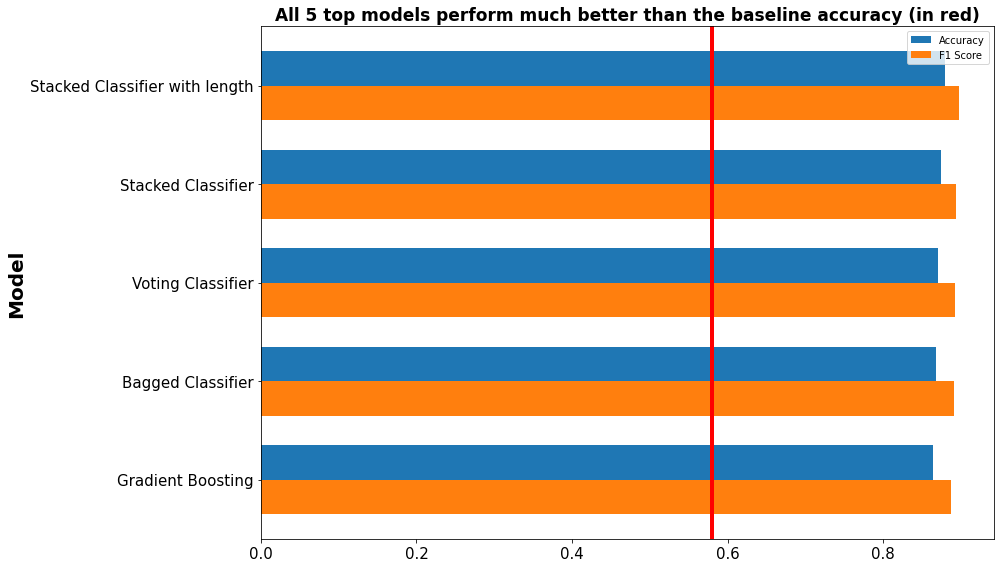

In [604]:

p = models.plot(x = 'Model',
                   kind='barh', 
                   stacked=False, 
                   figsize=(14,8), 
                   fontsize=15, width = 0.7)

p.axvline(linewidth=4, color='r', x=0.58)

p.invert_yaxis()
plt.legend(loc='upper right')
plt.title('All 5 top models perform much better than the baseline accuracy (in red)', size=17, fontweight='bold')
plt.ylabel('Model', size=20, fontweight='bold'),
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('../images/top_models.png', dpi=300);

## Are there posts that our two top models are both misclassifying? 

In [557]:
def miss(preds):
    """
    Function returns a dataframe of misclassified posts when predicted values
    are provided as arguments. 
    `preds` can be any model's model.predict(X_test) result
    """
    df = pd.DataFrame()
    df['predictions'] = preds 
    df['true_values'] = list(y_test)
    df['title'] = list(X_test)
    return df[df['predictions'] != df['true_values']]

In [558]:
#Testing function on one of our predictions

miss(y_pred_9).head()

,predictions,true_values,title
7,cars,electricvehicles,Flat Out in My Rimac Nevera in Monaco! 0-100 i...
12,electricvehicles,cars,"U.S. auto sales to fall in 2022, GM set to rec..."
23,electricvehicles,cars,A Farewell to the Internal Combustion Engine
24,electricvehicles,cars,"For U.S. Companies, the Race for the New EV Ba..."
26,electricvehicles,cars,Hello! I am a research student researching the...


In [568]:
#How many posts are being misclassified by both our top performing model and the next best performing model?

a = miss(y_pred_10)  #our top model
b = miss(y_pred_7)   #our second top model

print(f'Our top model is misclassifying {a.shape[0]} posts')
print(f'Our next best model is misclassifying {b.shape[0]} posts')

total = 0
for r in a.index:
    if r in b.index:
        total+=1
print(f'There are {total} posts that are being misclassified both by our top model and the next best model')

Our top model is misclassifying 225 posts
Our next best model is misclassifying 235 posts
There are 210 posts that are being misclassified both by our top model and the next best model


In [598]:
#Look at some of the posts being misclassified
explore = a.head()
explore

,predictions,true_values,title
7,cars,electricvehicles,Flat Out in My Rimac Nevera in Monaco! 0-100 i...
12,electricvehicles,cars,"U.S. auto sales to fall in 2022, GM set to rec..."
23,electricvehicles,cars,A Farewell to the Internal Combustion Engine
24,electricvehicles,cars,"For U.S. Companies, the Race for the New EV Ba..."
26,electricvehicles,cars,Hello! I am a research student researching the...


In [596]:
#Consider the last two posts
[a['title'][i] for i in explore.index[-2:]]

['For U.S. Companies, the Race for the New EV Battery Is On',
 'Hello! I am a research student researching the opinions on electric cars. Please help me by completing my 1-minute survey for this project. Thank you.']

**The last post from above reads thus**: 

>Hello! I am a research student researching the opinions on electric cars. Please help me by completing my 1-minute survey for this project. Thank you. 

If anyone had shown this to me and asked me to guess which subreddit it would belong to, I'll most likely go for `r/electricvehicles`. That's sensible. And that's what our models went for. The problem is it was actually posted in the `r/cars` subreddit. 

**Next to it**

>For U.S. Companies, the Race for the New EV Battery Is On

Another one for which I would have chosen the `r/electricvehicles` subreddit - just like our models did - but was actually posted in the `r/cars` subreddit.

There were several others like these from either class, wrongly predicted by the model, but which truly could have gone either way. This is not surprising. The two subreddits are very similar, and arguably a majority of posts shared on one could legitimately be shared on the other. Considering all that, I believe that an accuracy of 88% is solid. 

## Conclusions & Recommendations

Recall that my assignment was to:
1. Collect more data from the two subreddits, using [Pushshift's](https://github.com/pushshift/api) API.
**Outcome: I collected enough data from the two subreddits. The number was high enough to give me confidence about my models' abilities to solve the task.** 

2. Use Natural Language Processing to train a classifier on which subreddit a given post came from. 
**Outcome: I trained several high performing predictive models with accuracies far above the baseline. I was informed that before the model can be put into production, it had to either achieve 90% accuracy or an F1 score of 90%. While none of my models managed to reach 90% accuracy, one of my models achieved an F1 score of 90%. That model was a stacked classifier comprising of LogisticRegression, Multinomial Naive Bayes, RandomForestClassifier, and Bagging Classifier as the first level estimators; and a Logisticregression model as the final estimator.** 

3. Make a presentation outlining my process and findings.
**A powerpoint presentation is included in this project and would be delivered as requested.** 

**My recommendations are as follows:**
- I have submitted my findings as requested, but if there is more time I would love to incorporate the texts of the posts as well. I only used the titles in this instance, but I believed that adding the texts could further help my models in differentiating between the classes. 
- I recommend that my Stacked Classifier which got the highest F1 score be put into production as it meets the 0.90 F1 score criteria. Further its other metrics, including an accuracy of 88% and a misclassification rate of 12 out of 100 is solid enough to proceed with. 